# Some recipes for analysing document data from the apsis platform

Using python on the APSIS server, we can interact directly with the database and easily traverse the relationships between the database's different tables

Here are a few examples plotting some basic scientometric data

In [1]:
# Load some libraries for reading the data from the database and plotting 

import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

from django.db.models import Count, Sum

In [2]:
# get the query we are interested in -- 
q = Query.objects.get(pk=5973) # This one is a demo query on shakespeare

# get the documents associated with the query
docs = Doc.objects.filter(query=q)

#how many documents do we have?
docs.count()

800

In [3]:
# how many documents in each year?
by_year = docs.values('PY').annotate(
    n = Count('pk') # Count the pk - primary keys - of documents in each value of PY (year)
).order_by('PY')

# Put this into a dataframe
by_year_df = pd.DataFrame.from_dict(list(by_year)) # we have to wrap the queryset in a list, so pandas can read it properly
by_year_df.tail() # what do the last few rows look like?


,PY,n
16,2014,47
17,2015,83
18,2016,107
19,2017,174
20,2018,261


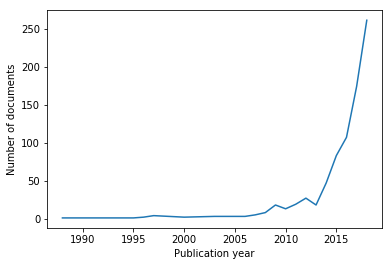

In [4]:
# make a plot!
plt.plot(by_year_df['PY'],by_year_df['n'])
# Add some labels
plt.xlabel('Publication year')
plt.ylabel('Number of documents')

In [5]:
# What categories are these documents in?
# The double underscore __ indicates that we are traversing across a linked table
# in this case we return the text attribut of the wc (web of science category) objects
# which are linked to our set of documents (one document can be linked to several wcs)
doc_cat = docs.values('wc__text').annotate(
    n = Count('pk')
).order_by('-n')
doc_cat_df = pd.DataFrame.from_dict(list(doc_cat)) 
doc_cat_df.head()


,n,wc__text
0,148,Environmental Studies
1,143,Energy & Fuels
2,126,Environmental Sciences
3,106,None
4,84,Economics


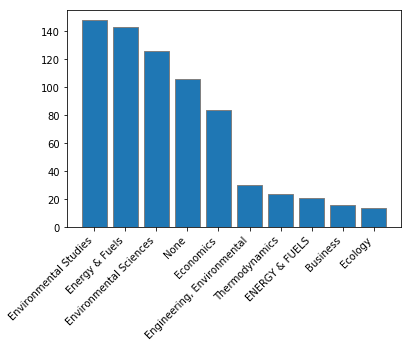

In [6]:
# Another graph!
fig, ax = plt.subplots()

pdf = doc_cat_df.head(10) #let's just show the top 10 categories

# Matplotlib doesn't much like categorical values, so set x positions with \
# the index of the dataframe [0-n]
ax.bar(pdf.index,pdf['n'],edgecolor="grey") 
# then we make sure there is a tick on each position
ax.set_xticks(pdf.index)
# And set the tick labels to the categories
ax.set_xticklabels(pdf['wc__text'])
# And rotate them
plt.xticks(rotation=45,ha="right")

plt.show()

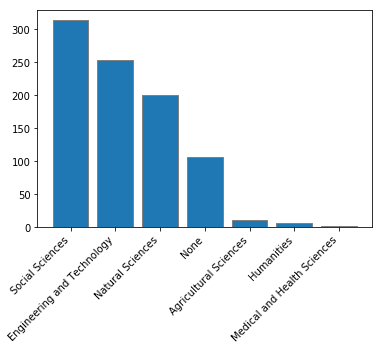

In [7]:
# And now the OECD categories
doc_cat = docs.values('wc__oecd').annotate(
    n = Count('pk')
).order_by('-n')

pdf = pd.DataFrame.from_dict(list(doc_cat)) 

fig, ax = plt.subplots()

ax.bar(pdf.index,pdf['n'],edgecolor="grey")
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['wc__oecd'])
plt.xticks(rotation=45,ha="right")

plt.show()

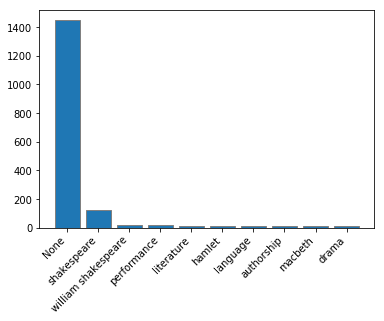

In [8]:
# Same goes for keywords - looks like a lot of these documents don't have keywords for some reason?
doc_kw = docs.values('kw__text').annotate(
    n = Count('pk')
).order_by('-n')
doc_kw_df = pd.DataFrame.from_dict(list(doc_kw)) 
doc_kw_df.head()

pdf = doc_kw_df.head(10)

fig, ax = plt.subplots()

ax.bar(pdf.index,pdf['n'],edgecolor="grey")
ax.set_xticks(pdf.index)
ax.set_xticklabels(pdf['kw__text'])
plt.xticks(rotation=45,ha="right")

plt.show()

In [ ]:
docs = Doc.objects.